In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.io import loadmat

In [2]:
mat = loadmat('CD_PD.mat', squeeze_me=True)
datas = mat['dat']

In [3]:
features = ['age', 'ed', 'gender', 'side', 'TMSE']
sampleSize = datas.shape[0]
df = pd.DataFrame(index = [i for i in range(sampleSize)], columns = features)
for i in range(sampleSize):
    for j in range(len(features)):
        df.loc[i, features[j]] = datas[i][features[j]]
        
edUnique = df['ed'].unique()
edDict = {}
for i in range(len(edUnique)):
    edDict[edUnique[i]] = edUnique[i][0]

genderUnique = df['gender'].unique()
genderDict = {}
for i in range(len(genderUnique)):
    genderDict[genderUnique[i]] = genderUnique[i][0]

sideUnique = df['side'].unique()
sideDict = {}
for i in range(len(sideUnique)):
    sideDict[sideUnique[i]] = sideUnique[i][0]
    
df['ed'] = df['ed'].replace(edDict)
df['gender'] = df['gender'].replace(genderDict)
df['side'] = df['side'].replace(sideDict)

df = df.astype('float64')

df = df.drop(df.loc[df['age'] == 0].index)
df = df.drop(df.loc[df['TMSE'] == 0].index)
df = df.reset_index(drop=True)
sampleSize = df.shape[0]

for i in range(sampleSize):
    if df.loc[i, 'ed'] == 0:
        if df.loc[i, 'TMSE'] >= 19:
            df.loc[i, 'pass'] = 1
        else:
            df.loc[i, 'pass'] = 0
    elif df.loc[i, 'ed'] == 1:
        if df.loc[i, 'TMSE'] >= 23:
            df.loc[i, 'pass'] = 1
        else:
            df.loc[i, 'pass'] = 0
    elif df.loc[i, 'ed'] == 2 or df.loc[i, 'ed'] == 3:
        if df.loc[i, 'TMSE'] >= 27:
            df.loc[i, 'pass'] = 1
        else:
            df.loc[i, 'pass'] = 0
    elif df.loc[i, 'ed'] >= 4:
        if df.loc[i, 'TMSE'] >= 29:
            df.loc[i, 'pass'] = 1
        else:
            df.loc[i, 'pass'] = 0

from statistics import mean

speedList = []
timeDiffMeanList = []
timeUsedList = []

for i in range(sampleSize):
    t = datas[i]['t']
    x = datas[i]['x']
    y = datas[i]['y']
    n = t.shape[0]
    
    timeUsed = t[-1]
    timeUsedList.append(timeUsed)
    
    speed = []
    timeDiffList = []
    for j in range(n-1):
        timeDiff = t[j+1] - t[j]
        if timeDiff == 0:
            continue
        
        xDiff = abs(x[j+1] - x[j])
        yDiff = abs(y[j+1] - y[j])
        length = (xDiff ** 2 + yDiff ** 2) ** 0.5
        speed.append(length / timeDiff)
        
        timeDiffList.append(timeDiff)
        
    spMean = mean(speed)
    speedList.append(spMean)
    timeDiffMean = mean(timeDiffList)
    timeDiffMeanList.append(timeDiffMean)
    
for i in range(sampleSize):
    df.loc[i, 'speed'] = speedList[i]
    df.loc[i, 'time_diff_mean'] = timeDiffMeanList[i]
    df.loc[i, 'time_used'] = timeUsedList[i]

labels = ['diagnosis', 'clock_drawing']
for i in range(sampleSize):
    for j in range(len(labels)):
        df.loc[i, labels[j]] = datas[i][labels[j]]

In [4]:
dropIndex = df[df['diagnosis'] == 1].sample(n=56, random_state = 0).index
dfDropped = df.drop(dropIndex)
dfDropped = dfDropped.sample(n = dfDropped.shape[0], random_state = 0)
dfDropped = dfDropped.reset_index()

In [5]:
X = dfDropped.iloc[:, :-2]
Y = dfDropped.loc[:, 'diagnosis':'clock_drawing']

y_diag = dfDropped['diagnosis']
y_clk = dfDropped['clock_drawing']

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)

y_train_diag = Y_train['diagnosis']
y_train_clk = Y_train['clock_drawing']
y_test_diag = Y_test['diagnosis']
y_test_clk = Y_test['clock_drawing']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X = scaler.transform(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# <font color=blue>SVC</font>

In [6]:
from sklearn.svm import SVC

svc1 = SVC(kernel = 'linear', C = 1).fit(X_train, y_train_diag)

print(svc1.score(X_test, y_test_diag))

svc2 = SVC(kernel = 'linear', C = 10).fit(X_train, y_train_clk)
print(svc2.score(X_test, y_test_clk))

0.7333333333333333
0.7333333333333333


In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
y_pred1 = svc1.predict(X_test)
print(confusion_matrix(y_test_diag, y_pred1))
print()
roc_auc1 = roc_auc_score(y_test_diag, y_pred1)
print(roc_auc1)
print()
print(classification_report(y_test_diag, y_pred1))

[[10  1]
 [ 7 12]]

0.7703349282296651

             precision    recall  f1-score   support

        0.0       0.59      0.91      0.71        11
        1.0       0.92      0.63      0.75        19

avg / total       0.80      0.73      0.74        30



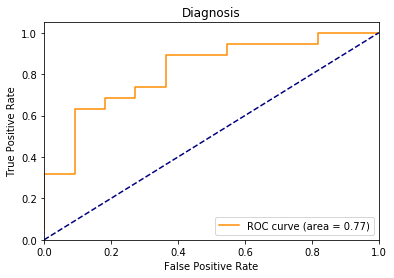

In [8]:
from sklearn.metrics import roc_curve
y_diag_scores = svc1.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test_diag, y_diag_scores)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Diagnosis')
plt.legend(loc="lower right")
plt.show()

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
y_pred2 = svc2.predict(X_test)
print(confusion_matrix(y_test_clk, y_pred2))
print()
roc_auc2 = roc_auc_score(y_test_clk, y_pred2)
print(roc_auc2)
print()
print(classification_report(y_test_clk, y_pred2))

[[14  6]
 [ 2  8]]

0.75

             precision    recall  f1-score   support

        0.0       0.88      0.70      0.78        20
        1.0       0.57      0.80      0.67        10

avg / total       0.77      0.73      0.74        30



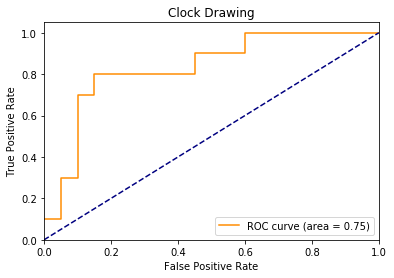

In [10]:
y_clk_scores = svc2.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test_clk, y_clk_scores)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Clock Drawing')
plt.legend(loc="lower right")
plt.show()

In [11]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svc1, X, y_diag, cv=5)
print(scores)

[0.83333333 0.79166667 0.79166667 0.83333333 0.79166667]


In [12]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svc2, X, y_clk, cv=5)
print(scores)

[0.8        0.75       0.75       0.58333333 0.69565217]


In [13]:
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
# parameters = {'kernel':['linear'], 'C':[0.01, 0.1, 1, 10, 100]}
# gsClf = GridSearchCV(SVC(), parameters, return_train_score=False).fit(X, y_diag)
# gsClf.cv_results_

In [14]:
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
# parameters = {'kernel':['linear'], 'C':[0.01, 0.1, 1, 10, 100]}
# gsClf = GridSearchCV(SVC(), parameters, return_train_score=False).fit(X, y_clk)
# gsClf.cv_results_

# <font color=green>Random Forest</font>

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc1 = RandomForestClassifier(random_state = 1).fit(X_train, y_train_diag)
print(rfc1.score(X_test, y_test_diag))
scores1 = cross_val_score(rfc1, X, y_diag, cv=5)
print(scores1)
print()
rfc2 = RandomForestClassifier(random_state = 1).fit(X_train, y_train_clk)
print(rfc2.score(X_test, y_test_clk))
scores2 = cross_val_score(rfc2, X, y_clk, cv=5)
print(scores2)

0.7333333333333333
[0.79166667 0.83333333 0.70833333 0.875      0.875     ]

0.7
[0.64       0.70833333 0.75       0.625      0.7826087 ]


In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

y_pred1 = rfc1.predict(X_test)
print(confusion_matrix(y_test_diag, y_pred1))
print()
roc_auc1 = roc_auc_score(y_test_diag, y_pred1)
print(roc_auc1)
print()
print(classification_report(y_test_diag, y_pred1))

[[ 7  4]
 [ 4 15]]

0.7129186602870813

             precision    recall  f1-score   support

        0.0       0.64      0.64      0.64        11
        1.0       0.79      0.79      0.79        19

avg / total       0.73      0.73      0.73        30



In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

y_pred2 = rfc2.predict(X_test)
print(confusion_matrix(y_test_clk, y_pred2))
print()
roc_auc2 = roc_auc_score(y_test_clk, y_pred2)
print(roc_auc2)
print()
print(classification_report(y_test_clk, y_pred2))

[[15  5]
 [ 4  6]]

0.675

             precision    recall  f1-score   support

        0.0       0.79      0.75      0.77        20
        1.0       0.55      0.60      0.57        10

avg / total       0.71      0.70      0.70        30



# <font color=orange>Neural Networks</font>

In [18]:
pic = np.ndarray((dfDropped.shape[0], 205, 205, 3))
index = 0
for i in range(sampleSize):
    if i in dropIndex:
        continue
    dataSize = datas[i]['x'].shape[0]
    xMin = 1000
    xMax = 0
    yMin = 1000
    yMax = 0
    for j in range(dataSize):
        x_raw = int(datas[i]['x'][j] / 5)
        y_raw = int(datas[i]['y'][j] / 5)
        if x_raw < xMin:
            xMin = x_raw
        if x_raw > xMax:
            xMax = x_raw
        if y_raw < yMin:
            yMin = y_raw
        if y_raw > yMax:
            yMax = y_raw
    xDist = xMax - xMin
    yDist = yMax - yMin
    for j in range(dataSize):
        x = int((datas[i]['x'][j] / 5 - xMin + 1) / xDist * 200)
        y = int((datas[i]['y'][j] / 5 - yMin + 1) / yDist * 200)
        t = datas[i]['t'][j]
        p = datas[i]['p'][j]
        pt = datas[i]['pt'][j]
        if pic[index,x,y,0] >= 0:
            pic[index,x,y,0] = (t + pic[index,x,y,0]) / 2
        else:
            pic[index,x,y,0] = t
        if pic[index,x,y,1] >= 0:
            pic[index,x,y,1] = (p + pic[index,x,y,1]) / 2
        else:
            pic[index,x,y,1] = p
        if pic[index,x,y,2] >= 0:
            pic[index,x,y,2] = (pt + pic[index,x,y,2]) / 2
        else:
            pic[index,x,y,2] = pt
    index += 1

Xn = pic.reshape(len(pic), -1)

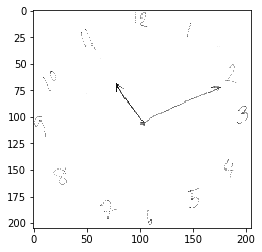

In [19]:
plt.imshow(pic[0,:,:,1].T, cmap='binary')
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

Y = dfDropped.loc[:, 'diagnosis':'clock_drawing']
Xn_train, Xn_test, Y_train, Y_test = train_test_split(Xn, Y, random_state = 0)
y_train_diag = Y_train['diagnosis']
y_train_clk = Y_train['clock_drawing']
y_test_diag = Y_test['diagnosis']
y_test_clk = Y_test['clock_drawing']

In [21]:
from sklearn.neural_network import MLPClassifier

nn1 = MLPClassifier(solver = 'adam', alpha = 0.01, hidden_layer_sizes = [20,10], random_state = 0)
nn1.fit(Xn_train, y_train_diag)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[20, 10], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [22]:
nn1.score(Xn_test, y_test_diag)

0.6666666666666666

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
y_pred1 = nn1.predict(Xn_test)
print(confusion_matrix(y_test_diag, y_pred1))
print()
roc_auc1 = roc_auc_score(y_test_diag, y_pred1)
print(roc_auc1)
print()
print(classification_report(y_test_diag, y_pred1))

[[ 5  6]
 [ 4 15]]

0.6220095693779905

             precision    recall  f1-score   support

        0.0       0.56      0.45      0.50        11
        1.0       0.71      0.79      0.75        19

avg / total       0.66      0.67      0.66        30



In [24]:
from sklearn.neural_network import MLPClassifier

nn2 = MLPClassifier(solver = 'adam', hidden_layer_sizes = [20,10], random_state = 0)
nn2.fit(Xn_train, y_train_clk)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[20, 10], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [25]:
nn2.score(Xn_test, y_test_clk)

0.4

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
y_pred2 = nn2.predict(Xn_test)
print(confusion_matrix(y_test_clk, y_pred2))
print()
roc_auc2 = roc_auc_score(y_test_clk, y_pred2)
print(roc_auc2)
print()
print(classification_report(y_test_clk, y_pred2))

[[ 5 15]
 [ 3  7]]

0.475

             precision    recall  f1-score   support

        0.0       0.62      0.25      0.36        20
        1.0       0.32      0.70      0.44        10

avg / total       0.52      0.40      0.38        30

